## Data manipulation

In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import numpy
import ipywidgets as widgets
from IPython.display import display

In [33]:
from dataclasses import dataclass

@dataclass
class Statistics:
    count_years: int = None
    count_fill_values: int = None
    mean_value: float = None
    median_value: float = None
    max_value: int = None
    max_value_year: int = None
    min_value: float = None
    min_value_year: float = None
    standard_deviation: float = None
    min_range_year: None = None
    max_range_year: None = None # otázka zda používat, je to informace pro range widget
    
    def calculate_from_data(self, data, code):
        if code == '1-1':
            value_column = data['value']
            
            self.count_years = data['year'].count()
            self.count_fill_values = value_column.count()
            count_unfill_values = self.count_years - self.count_fill_values

            self.mean_value = round(value_column.mean(), 2)
            self.median_value = value_column.median()

            max_value_row = data.loc[data['value'].idxmax()]
            min_value_row = data.loc[data['value'].idxmin()]

            self.max_value, self.max_value_year = max_value_row[['value', 'year']]
            self.min_value, self.min_value_year = min_value_row[['value', 'year']]

            # použita populační směrodatná odchylka, ddof=1 ->nastavení na výběrovou směrodatnou odchylku
            self.standard_deviation = round(numpy.std(value_column), 2)

            # TODO: nutno pořešit v rámci změny filtrování, např. pokud budu mít všechny země, tento údaj úplně nědává smysl, 
            self.min_range_year = data['year'].min() 
            self.max_range_year = data['year'].max()
        elif code == '1-all':
            pass
        
        elif code == 'all-1':
            pass

        elif code == 'all-all':
            pass


@dataclass
class EurostatCrimeTable:
    data: pd.DataFrame = None
    country: str = None
    crime: str = None
    filtered_data: pd.DataFrame = None
    filtered_code: None = None
    statistics: Statistics = None
    statistics_info: str = None
    
    def load_data(self, path):
        data = pd.read_csv(path, sep='\t')
        
        data = data.rename({data.columns[0]: data.columns[0].replace(r"\TIME_PERIOD", "")}, axis="columns")
        split_name_columns = (data.columns[0]).split(',')
        count_split_columns = len(split_name_columns)
        data[split_name_columns] = data[data.columns[0]].str.split(',', expand=True)
        data = data.drop(data.columns[0], axis="columns") #odstraneni jiz rozdeleneho sloupce


        %run data/add_info.ipynb
        data = data.merge(geo_df, how='left', on='geo')
        data = data.merge(iccs_df, how='left', on='iccs')
        data = data.drop(columns=['geo', 'iccs'])

        # presun rozdelenych a naparovaných udaju  na zacatek df
        reorg_columns = data.columns.tolist()
        final_reorg_columns = reorg_columns[-count_split_columns:] + reorg_columns[:-count_split_columns]
        data = data[final_reorg_columns]

        data = data.replace(": ", 'NaN')

        column_period = data.columns[count_split_columns:] 
        data[column_period] = data[data.columns[count_split_columns:]].astype('float')
        
        no_anual = data[data['freq'] != 'A'].index # podminka, ze se nejedna o rocni data
        data.drop(index=no_anual, inplace=True)

        no_p_hthab = data[data['unit'] != 'P_HTHAB'].index # podminka, ze se nejedna o udaj na 100tis obyvatel
        data.drop(index=no_p_hthab, inplace=True)

        years_list = data.columns[count_split_columns:]
        info_list = data.columns[:count_split_columns]

        unpivot_data = pd.melt(data, id_vars=info_list, value_vars=years_list, var_name='year', value_name='value')
        unpivot_data['year'] = unpivot_data['year'].astype('int')
        self.data = unpivot_data
    

    def filter_data(self, country, crime):
        self.country = country
        self.crime = crime

        if country != 'all' and crime != 'all':
            filtered_data = self.data[(self.data['country_name'] == country) & (self.data['crime_info'] == crime)]
            self.filtered_data = filtered_data.sort_values(by='year', axis=0, ascending=True)
            self.filtered_code = '1-1'

        elif country != 'all' and crime == 'all':
            self.filtered_data = self.data[self.data['country_name'] == country]
            self.filtered_code = '1-all'

        elif country == 'all' and crime != 'all':
            self.filtered_data = self.data[self.data['crime_info'] == crime]
            self.filtered_code = 'all-1'

        elif country == 'all' and crime == 'all':
            self.filtered_data = self.data
            self.filtered_code = 'all-all'


    def get_statistics(self):
        data = self.filtered_data
        code = self.filtered_code

        stat = Statistics()
        stat.calculate_from_data(data, code)
        self.statistics = stat

        self.statistics_info = f'During a {stat.count_years}-year period, {self.country} recorded {stat.count_fill_values} entries for {self.crime} types of crime. Across these years, there were an average of {stat.mean_value} crimes per hundred thousand inhabitants each year and standard deviation was {stat.standard_deviation}. The minimum recorded crime rate per hundred thousand inhabitants was {stat.min_value} in {stat.min_value_year}, while the maximum was {stat.max_value} in {stat.max_value_year}.'

        pass # TODO: vyřešit info o státu/kriminalitě
        # TODO: 
        # přidat dodatečné  informace o směrodané odchylně
        # přidat info o násobku z min -> max aj
        # od jakého roku začal stát poskytovat/sbírat data - zmenit automaticky range ve widgete
        # vytvorit slovnik jako zaznamnik pro porovnani s ostatnimi zememi průmery, max, min v ráci tr. činnu
      
        
    def __str__(self):
        print(f'info {self.statistics}')


In [34]:
CrimeData = EurostatCrimeTable()
CrimeData.load_data(f'data/estat_crim_off_cat.tsv')


In [35]:
country_list_sorted = sorted(list(set(CrimeData.data['country_name'].tolist())))
country_list_sorted.insert(0, 'all')

crime_list_sorted = sorted(list(set(CrimeData.data['crime_info'].tolist())))
crime_list_sorted.insert(0, 'all')

In [36]:
country = widgets.Dropdown(
    options=country_list_sorted,
    value=country_list_sorted[1],
    description='Country:',
    disabled=False,
    )
crime = widgets.Dropdown(
    options=crime_list_sorted,
    value=crime_list_sorted[1],
    description='Crime:',
    disabled=False,
    )
display(country)
display(crime)

Dropdown(description='Country:', index=1, options=('all', 'Albania', 'Austria', 'Belgium', 'Bosnia and Herzego…

Dropdown(description='Crime:', index=1, options=('all', 'Acts against computer systems', 'Attempted intentiona…

In [37]:
select_country = country.value
select_crime = crime.value

In [38]:
select_crime
select_country

'France'

In [39]:
CrimeData.filter_data(select_country, select_crime)


In [40]:
select_filter = CrimeData.filtered_data
select_filter

,freq,unit,country_name,crime_info,year,value
628,A,P_HTHAB,France,Corruption,2008,NaN
1402,A,P_HTHAB,France,Corruption,2009,NaN
2176,A,P_HTHAB,France,Corruption,2010,NaN
2950,A,P_HTHAB,France,Corruption,2011,NaN
3724,A,P_HTHAB,France,Corruption,2012,NaN
4498,A,P_HTHAB,France,Corruption,2013,NaN
5272,A,P_HTHAB,France,Corruption,2014,NaN
6046,A,P_HTHAB,France,Corruption,2015,NaN
6820,A,P_HTHAB,France,Corruption,2016,3.01
7594,A,P_HTHAB,France,Corruption,2017,2.94


In [41]:
CrimeData.get_statistics()

In [42]:
CrimeData.statistics.max_value_year
CrimeData.statistics_info

'During a 15-year period, France recorded 7 entries for Corruption types of crime. Across these years, there were an average of 3.45 crimes per hundred thousand inhabitants each year and standard deviation was 0.35. The minimum recorded crime rate per hundred thousand inhabitants was 2.94 in 2017, while the maximum was 4.04 in 2021.'

In [43]:
CrimeData.statistics.standard_deviation

np.float64(0.35)

In [44]:
CrimeData.statistics.mean_value

np.float64(3.45)

## Data visualisation

In [45]:
# TODO: propojit widgetu s grafem, aby byl rovnou interaktivní, pozor na dublo, trublo grafů

In [46]:
years_range = widgets.IntRangeSlider(
    value=[CrimeData.statistics.min_range_year, CrimeData.statistics.max_range_year],
    min=CrimeData.statistics.min_range_year,
    max=CrimeData.statistics.max_range_year,
    step=1,
    description='Years:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,   
    readout_format='d',

)
years_range

IntRangeSlider(value=(2008, 2022), continuous_update=False, description='Years:', max=2022, min=2008)

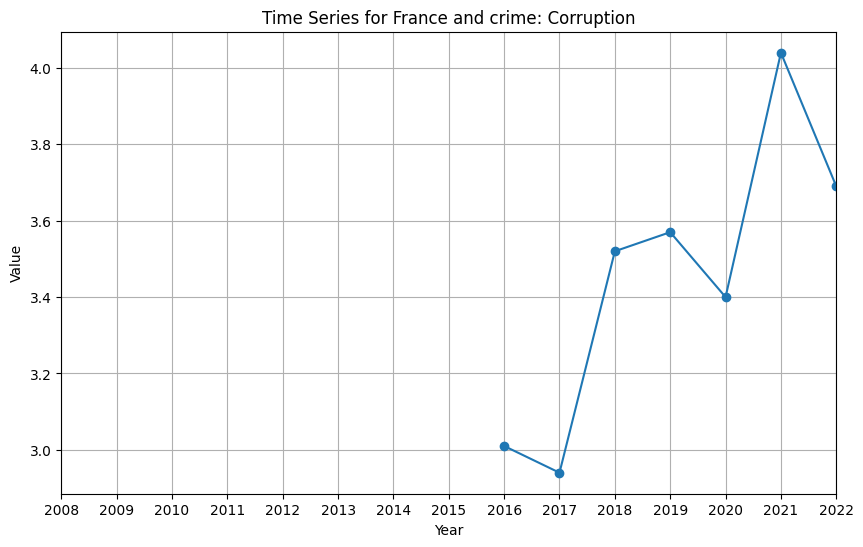

In [47]:
start_year, end_year = years_range.value
plt.figure(figsize=(10, 6))
plt.plot(CrimeData.filtered_data['year'], CrimeData.filtered_data['value'], marker='o')
plt.title(f"Time Series for {country.value} and crime: {crime.value}")
plt.xlabel("Year")
plt.ylabel("Value")
plt.grid(True)
plt.xlim(start_year, end_year)
plt.xticks(range(start_year, end_year + 1, 1))
plt.show()

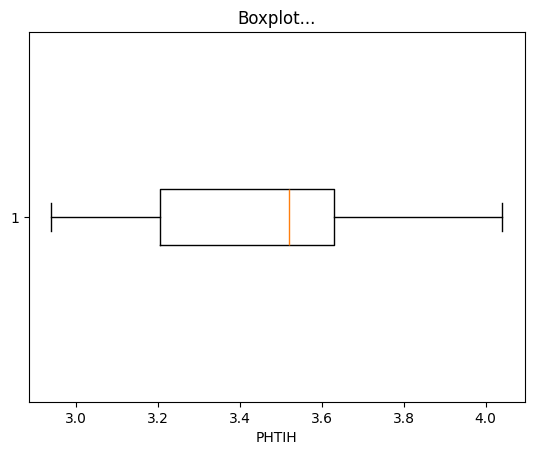

In [48]:
plt.boxplot(CrimeData.filtered_data['value'].dropna(), vert=False, showfliers=True)
plt.xlabel('PHTIH')
plt.title('Boxplot...')

# Show plot
plt.show()

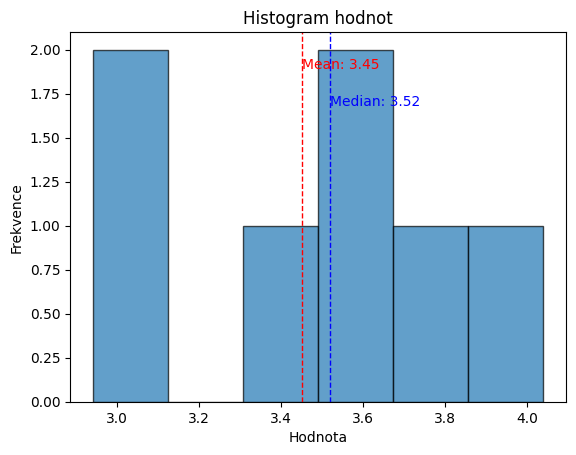

In [49]:
# import seaborn as sns
# sns.histplot(CrimeData.filtered_data['value'], bins=6, kde=True)
plt.hist(CrimeData.filtered_data['value'], bins=6, edgecolor='black', alpha=0.7)

# Přidání názvů a popisků
plt.title('Histogram hodnot')
plt.xlabel('Hodnota')
plt.ylabel('Frekvence')

# Mean line
plt.axvline(CrimeData.statistics.mean_value, color = 'red', linestyle='dashed', linewidth=1)
plt.text(CrimeData.statistics.mean_value, plt.ylim()[1]*0.9, f'Mean: {CrimeData.statistics.mean_value:.2f}', color = 'red')

# Median line
plt.axvline(CrimeData.statistics.median_value, color='blue', linestyle='dashed', linewidth=1)
plt.text(CrimeData.statistics.median_value, plt.ylim()[1]*0.8, f'Median: {CrimeData.statistics.median_value:.2f}', color='blue')



# Zobrazení grafu
plt.show()